# Love Number Sensitivity
In this cookbook we will explore how we can use TidalPy's multilayer functions to estimate the response of a planet to tidal or other loading stresses via the complex Love numbers.

**References**:
- SVC16  : Sabadini, Vermeerson, & Cambiotti (2016), DOI: [10.1007/978-94-017-7552-6](https://doi.org/10.1007/978-94-017-7552-6).
- HH14   : Henning & Hurford (2014), DOI: [10.1088/0004-637X/789/1/30](https://doi.org/10.1088/0004-637X/789/1/30).
- TB05   : Tobie et al. (2005), DOI: [10.1016/j.icarus.2005.04.006](https://doi.org/10.1016/j.icarus.2005.04.006).
- S74    : Saito (1974), DOI: [10.4294/jpe1952.22.123](https://doi.org/10.4294/jpe1952.22.123).
- TS72   : Takeuchi & Saito (1972), DOI: [10.1016/B978-0-12-460811-5.50010-6](http://dx.doi.org/10.1016/B978-0-12-460811-5.50010-6).
- KMN15  : Kamata et al. (1972), DOI: [10.1002/2015JE004821](http://dx.doi.org/10.1002/2015JE004821).
- M16    : Martens (2016, [PhD Thesis](https://resolver.caltech.edu/CaltechTHESIS:04102016-211741759)), DOI: [10.7907/Z9N29TX7](http://dx.doi.org/10.7907/Z9N29TX7).
- ID     : [IcyDwarf Code](https://github.com/MarcNeveu/IcyDwarf/blob/master/IcyDwarf/Thermal.h) written by Marc Neveu.

In [1]:
import sys
import time
from functools import lru_cache

import numpy as np
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
%matplotlib widget

# Load TidalPy's Helper Functions
from TidalPy.utilities.conversions import days2rads
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays

# Load TidalPy's Rheology Functions
from TidalPy.rheology import Maxwell, Burgers, Andrade, Sundberg, Newton, Elastic

# Load TidalPy's RadialSolver Module
from TidalPy.RadialSolver import radial_solver, build_rs_input_homogeneous_layers

rheologies = {
    'Maxwell': Maxwell,
    'Burgers': Burgers,
    'Andrade': Andrade,
    'Sundberg-Cooper': Sundberg,
    'Newton': Newton,
    'Elastic': Elastic
}

integration_method = "RK45"

widget_styles = {
    'layout': {'width': '50%'},
    'style': {'description_width': 'initial'}
}

def clear_line():
    # Can't get ANSI escape codes to work properly in Jupyter so this is a hack.
    #   The ANSI code would be "\033[1A\033[K"
    print('\r                                             ', end='\r')

common_kwargs = dict(
    degree_l = 2,
    solve_for = None,
    starting_radius = 0.0,
    start_radius_tolerance = 1.0e-5,
    nondimensionalize = True,
    # Shooting method parameters
    use_kamata = True,
    integration_method = 'DOP853',
    integration_rtol = 1.0e-5,
    integration_atol = 1.0e-8,
    scale_rtols_bylayer_type = False,
    max_num_steps = 500_000,
    expected_size = 1000,
    max_ram_MB = 500,
    max_step = 0,
    # Propagation matrix method parameters
    use_prop_matrix = False,
    core_model = 0,
    # Equation of State solver parameters
    eos_method_bylayer = None,
    surface_pressure = 0.0,
    eos_integration_method = 'DOP853',
    eos_rtol = 1.0e-3,
    eos_atol = 1.0e-5,
    eos_pressure_tol = 1.0e-3,
    eos_max_iters = 40,
    # Error and log reporting
    verbose = False,
    warnings = False,
    raise_on_fail = False,
    perform_checks = True,
    log_info = False
)


## Setup functions

In [2]:
def calculate_planet(build_func, **build_func_kwargs):
    
    # Get basic info to setup the plot
    radius_fraction_tuple, rs_input_original = build_func('Elastic', 0.0, 
                                   False, False, False, False,
                                   **build_func_kwargs)

    planet_frequency = rs_input_original.frequency
    
    planet_radius = rs_input_original.radius_array[-1]
    radius_km = rs_input_original.radius_array / 1000.
    original_ic_frac   = radius_fraction_tuple[0]
    original_oc_frac   = radius_fraction_tuple[1]
    
    # Setup figure
    fig, axes = plt.subplots(figsize=(11, 7), ncols=3, nrows=2, sharey='all')
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show()
    tidal_lines = list()
    loading_lines = list()
    icb_lines = list()
    cmb_lines = list()
    twin_axes = list()
    for ax_i, ax in enumerate(axes.flatten()):
        ax2 = ax.twiny()
        twin_axes.append(ax2)
        if ax_i in [0, 3]:
            ax.set(ylabel='Radius [km]')
        ax.set(xlabel='$y_{' + f'{ax_i+1}' + '}$')
        tidal_lines.append((
            ax.plot([0], [0], c='blue', label='Tidal', ls='-')[0],
            ax2.plot([0], [0], c='blue', ls=':')[0]
        ))
        loading_lines.append((
            ax.plot([0], [0], c='orange', label='Loading', ls='-')[0],
            ax2.plot([0], [0], c='orange', ls=':')[0]
        ))
        icb_lines.append(ax.axhline(0, c='k', ls='--'))
        cmb_lines.append(ax.axhline(0, c='k', ls='--'))
    
#     @lru_cache
    def update_calculations(rheology_name, forcing_period, degree_l,
                            inner_core_frac, outer_core_frac,
                            solid_dynamic, liquid_dynamic, solve_load_numbers,
                            integration_atol, integration_rtol):
        # Use pre-defined frequency or user-defined
        if forcing_period == 0.:
            # Pre-defined
            frequency = planet_frequency
        else:
            # Use user-defined
            frequency = days2rads(forcing_period)
            
        # Rebuild planet with updated inner and outer core radii
        solid_incompressible = False
        liquid_incompressible = True
        radius_fraction_tuple, rs_input = build_func(rheology_name, frequency,
                              solid_dynamic, liquid_dynamic, solid_incompressible, liquid_incompressible,
                              inner_core_radius=inner_core_frac*planet_radius,
                              outer_core_radius=outer_core_frac*planet_radius,
                              **build_func_kwargs)

        solve_for = ['tidal']
        if solve_load_numbers:
            solve_for.append('loading')
        
        # Calculate radial solution
        integration_rtol = 10**integration_rtol
        integration_atol = 10**integration_atol

        specific_kwargs = {**common_kwargs}
        specific_kwargs['integration_rtol'] = integration_rtol
        specific_kwargs['integration_atol'] = integration_atol
        specific_kwargs['integration_method'] = integration_method
        specific_kwargs['solve_for'] = tuple(solve_for)
        specific_kwargs['degree_l'] = degree_l

        solution = radial_solver(*rs_input, **specific_kwargs)
        
        assert solution.success
        return solution
    
    def update(rheology_name, forcing_period, degree_l,
               inner_core_frac, outer_core_frac,
               solid_dynamic, liquid_dynamic, solve_load_numbers,
               integration_atol, integration_rtol):

        if inner_core_frac >= outer_core_frac:
            inner_core_frac = 0.99 * outer_core_frac
        if outer_core_frac <= inner_core_frac:
            outer_core_frac = 1.01 * inner_core_frac
        
        # Perform calculations
        clear_line()
        print('Calculating Radial Solution...', end='\r')
        t0 = time.time()
        solution = update_calculations(rheology_name, forcing_period, degree_l,
                                           inner_core_frac, outer_core_frac,
                                           solid_dynamic, liquid_dynamic, solve_load_numbers,
                                           integration_atol, integration_rtol)
        delta_t = time.time() - t0
        clear_line()
        out_str  = f'Completed in: {delta_t:0.4f}s. Degree l = {degree_l}. '
        if solve_load_numbers:
            k_tidal = solution.k[0]
            k_load = solution.k[1]
            h_tidal = solution.h[0]
            h_load = solution.h[1]
            l_tidal = solution.l[0]
            l_load = solution.l[1]
            out_str += f'Tidal k, h, l = {np.real(k_tidal):0.3f}, {np.real(h_tidal):0.3f}, {np.real(l_tidal):0.3f}. '
            out_str += f'Load k, h, l = {np.real(k_load):0.3f}, {np.real(h_load):0.3f}, {np.real(l_load):0.3f}.'
            print(out_str, end='\r')
        else:
            k_tidal = solution.k
            h_tidal = solution.h
            l_tidal = solution.l
            out_str += f'Tidal k, h, l = {np.real(k_tidal):0.3f}, {np.real(h_tidal):0.3f}, {np.real(l_tidal):0.3f}.'
            print(out_str, end='\r')
        
#         # Update plot axis
#         ax_radial.clear()
#         ax_tang.clear()
        
        # Update ICB/CMB reference lines
        for icb_line, cmb_line in zip(icb_lines, cmb_lines):
            icb_line.set_ydata([inner_core_frac*planet_radius/1000., inner_core_frac*planet_radius/1000.])
            cmb_line.set_ydata([outer_core_frac*planet_radius/1000., outer_core_frac*planet_radius/1000.])

        # Update Tidal Results
        for t_i, tidal_line_tuple in enumerate(tidal_lines):
            if solve_load_numbers:
                x_data = solution.result[t_i, :]
            else:
                x_data = solution.result[t_i, :]
            tidal_line_tuple[0].set_data(np.real(x_data), solution.radius_array/1000.)
            tidal_line_tuple[1].set_data(np.imag(x_data), solution.radius_array/1000.)
        
        # Update Loading Results
        for t_i, loading_line_tuple in enumerate(loading_lines):
            if solve_load_numbers:
                x_data = solution.result[t_i, :]
                loading_line_tuple[0].set_data(np.real(x_data), solution.radius_array/1000.)
                loading_line_tuple[1].set_data(np.imag(x_data), solution.radius_array/1000.)
            else:
                loading_line_tuple[0].set_data([0], [0])
                loading_line_tuple[1].set_data([0], [0])
            
        # Update limits
        for ax_i, ax in enumerate(axes.flatten()):
            ax.relim()
            ax.autoscale_view()
        for ax_i, ax in enumerate(twin_axes):
            ax.relim()
            ax.autoscale_view()
        
        # Reshow plot
        fig.canvas.draw()
        
    # Setup interactive plot
    interact(update,
             rheology_name = widgets.Dropdown(
                 options=['Maxwell', 'Burgers', 'Andrade', 'Sundberg-Cooper'],
                 value='Andrade',
                 description='Rheology:',
                 disabled=False, **widget_styles
             ),
             forcing_period = widgets.IntSlider(
                 min=0,
                 max=50,
                 step=1,
                 value=6,
                 description='Forcing Period [Days]:', **widget_styles
             ),
             degree_l = widgets.IntSlider(
                 min=2,
                 max=5,
                 step=1,
                 value=2,
                 description='Degree $l$:', **widget_styles
             ),
             inner_core_frac = widgets.FloatSlider(
                 value=original_ic_frac,
                 min=0.05,
                 max=0.9,
                 step=0.01,
                 description='IC-Fraction',
                 disabled=False,
                 readout_format='.2f',
                 indent=False, **widget_styles
             ),
             outer_core_frac = widgets.FloatSlider(
                 value=original_oc_frac,
                 min=0.15,
                 max=0.95,
                 step=0.01,
                 description='OC-Fraction',
                 disabled=False,
                 readout_format='.2f',
                 indent=False, **widget_styles
             ),
             solid_dynamic = widgets.Checkbox(
                 value=False,
                 description='Dynamic Solid',
                 disabled=False,
                 indent=False, **widget_styles
             ),
             liquid_dynamic = widgets.Checkbox(
                 value=False,
                 description='Dynamic Liquid (Unstable!)',
                 disabled=False,
                 indent=False, **widget_styles
             ),
             solve_load_numbers = widgets.Checkbox(
                 value=False,
                 description='Solve Load Numbers',
                 disabled=False,
                 indent=False, **widget_styles
             ),
             integration_atol = widgets.IntSlider(
                 min=-18,
                 max=-3,
                 step=1,
                 value=-7,
                 description='Integration atol ($10^{x}$):', **widget_styles
             ), 
             integration_rtol = widgets.IntSlider(
                 min=-18,
                 max=-3,
                 step=1,
                 value=-6,
                 description='Integration rtol ($10^{x}$):', **widget_styles
             ),
            )

## Four Layer Planet (Mercury-like)

In [3]:
from math import floor

def build_four_layer(rheology_name, frequency,
                     solid_dynamic, liquid_dynamic, solid_incompressible, liquid_incompressible,
                     inner_core_radius=None, outer_core_radius=None, crust_radius=None, quasi_liquid=False):
    # Numerical Settings
    N = 50

    # Build Planet
    # # Radius
    if inner_core_radius is None:
        inner_core_radius = 1500.0e3
    if outer_core_radius is None:
        outer_core_radius = 2000.0e3
    if crust_radius is None:
        crust_radius      = 2440.0e3
    mantle_radius = crust_radius - 100.0e3
    planet_radius = crust_radius
    
    # User may have provided unrealistic IC/OC fractions. Fix those here
    if inner_core_radius < 1.e3:
        inner_core_radius = 1.e3
    if outer_core_radius < 3.e3:
        outer_core_radius = 3.e3
    if inner_core_radius >= (outer_core_radius - 1.e3):
        inner_core_radius = outer_core_radius - 1.e3
    if outer_core_radius >= (mantle_radius - 1.e3):
        outer_core_radius = mantle_radius - 1.e3
    radius_fraction_tuple = (floor(1000*inner_core_radius/crust_radius)/1000,
                             floor(1000*outer_core_radius/crust_radius)/1000,
                             floor(1000*mantle_radius/crust_radius)/1000,
                             floor(1000*crust_radius/crust_radius)/1000)

    # Build RS inputs
    if quasi_liquid:
        layer_types = ("solid", "solid", "solid", "solid")
    else:
        layer_types = ("solid", "liquid", "solid", "solid")
    layer_is_static_tuple = (not solid_dynamic, not liquid_dynamic, not solid_dynamic, not solid_dynamic)
    layer_is_incompressible_tuple = (solid_incompressible, liquid_incompressible, solid_incompressible, solid_incompressible)

    shear_rheology_list = list()
    bulk_rheology_list = list()
    for i in range(4):
        shear_rheology_list.append(rheologies[rheology_name]())
        bulk_rheology_list.append(rheologies['Elastic']())

    density_tuple = (8750., 7850., 3200., 2600.)
    static_shear_modulus_tuple = (100.0e9, 0.0, 50.0e9, 10.0e9)
    static_bulk_modulus_tuple = (199.0e9, 80.0e9, 120.0e9, 90.0e9)
    shear_viscosity_tuple = (1.0e24, 1.0e3, 1.0e20, 1.0e26)
    bulk_viscosity_tuple = (1.0e30, 1.0e30, 1.0e30, 1.0e30)

    if frequency == 0.0:
        forcing_frequency = days2rads(87.96926)
    else:
        forcing_frequency = frequency
        
    rs_input = build_rs_input_homogeneous_layers(
        planet_radius,
        forcing_frequency,
        density_tuple,
        static_bulk_modulus_tuple,
        static_shear_modulus_tuple,
        bulk_viscosity_tuple,
        shear_viscosity_tuple,
        layer_types,
        layer_is_static_tuple,
        layer_is_incompressible_tuple,
        tuple(shear_rheology_list),
        tuple(bulk_rheology_list),
        radius_fraction_tuple = radius_fraction_tuple,
        thickness_fraction_tuple = None,
        volume_fraction_tuple = None,
        slices_tuple = None,
        slice_per_layer = N,
        perform_checks = True)

    return radius_fraction_tuple, rs_input

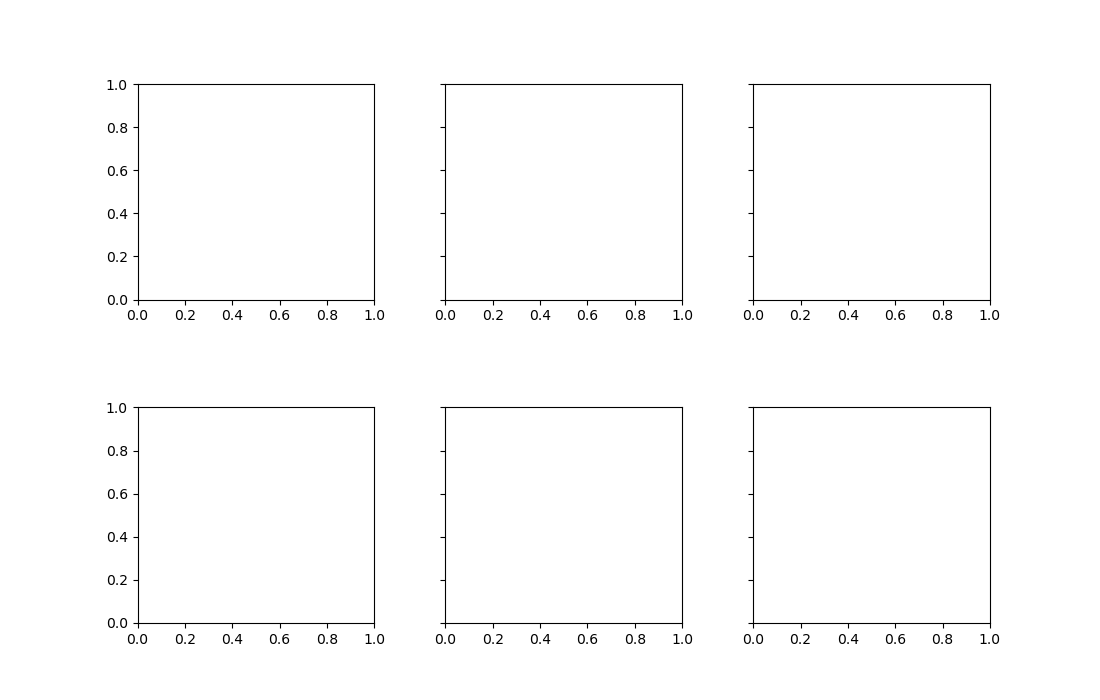

interactive(children=(Dropdown(description='Rheology:', index=2, layout=Layout(width='50%'), options=('Maxwell…

In [5]:
# Run Model!
calculate_planet(build_four_layer)